# 1D QM code check

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import pickle
np.random.seed(235)

quantum mudule

In [2]:
from QML.tools import quantum
from QML.main import ed, quantum_util

initialize parameters

In [3]:
# Some common used parameters

nk = 40  # number of k points in fstBZ
nG = 51  # number of basis vectors
X = np.linspace(0, 1, nG)  # real space grid
k_points = np.linspace(0, np.pi, nk)  # half of the fstBZ
Q = np.fft.rfftfreq(nG)

## Random potential generator

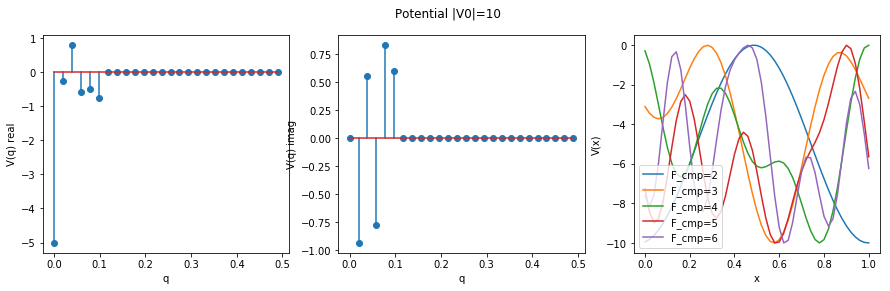

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
n = [2, 3, 4, 5, 6]
V0 = 10
for ni in n:
    Vq_1D = quantum.Vextq_1D(ni, nG, V0)
    Vx_1D = np.fft.irfft(Vq_1D, nG)*nG
    ax3.plot(X, Vx_1D, label='F_cmp=%s' %(ni))
ax1.stem(Q, Vq_1D.real)    
ax1.set_xlabel('q')
ax1.set_ylabel('V(q) real')
ax2.stem(Q, Vq_1D.imag)
ax2.set_xlabel('q')
ax2.set_ylabel('V(q) imag')
ax3.set_xlabel('x')
ax3.set_ylabel('V(x)')
ax3.legend()
plt.suptitle('Potential |V0|=10')
plt.show()

## Hamiltonian 

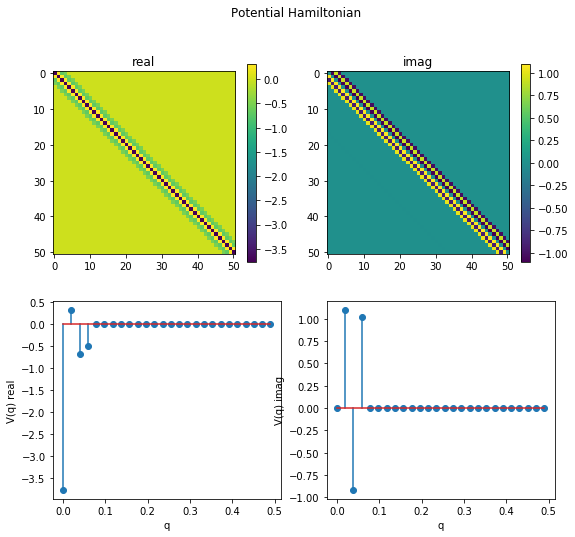

In [5]:
kx = 0
V0 = 10
Vq_1D = quantum.Vextq_1D(4, nG, V0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8))
V = ed.hamilton_operator_G_1D(kx, nG, Vq_1D, 0)
img1 = ax1.imshow(V.real)
ax1.set_title('real')
img2 = ax2.imshow(V.imag)
ax2.set_title('imag')
ax3.stem(Q, Vq_1D.real)
ax3.set_xlabel('q')
ax3.set_ylabel('V(q) real')
ax4.stem(Q, Vq_1D.imag)
ax4.set_xlabel('q')
ax4.set_ylabel('V(q) imag')

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.suptitle('Potential Hamiltonian')
plt.show()

## Special case

### Band structure & Kinetic energy & Electron density

electron number per cell: 2.3750


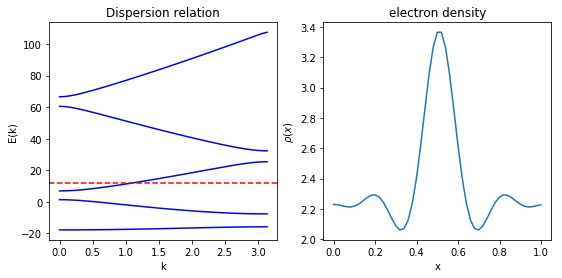

In [15]:
dmu = 30
Vq_1D = quantum.Vextq_1D(5, nG, 40)
en_band_1D, uq_1D = ed.solver1D(k_points, nG, Vq_1D)
mu = en_band_1D[0, 0] + dmu
densG_1D = quantum_util.density1D(nk, nG, mu, en_band_1D, uq_1D)
print('electron number per cell: %.4f' %(densG_1D[0]))

K_1D = np.linspace(0, np.pi, nk)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
for i in range(5):
    ax1.plot(K_1D, en_band_1D[:, i], 'b')
ax1.axhline(xmin=0, xmax=np.pi, y=mu, color='r', linestyle='--')
ax1.set_xlabel('k')
ax1.set_ylabel('E(k)')
ax1.set_title('Dispersion relation')

X_1D = np.linspace(0, 1, nG)
densX_1D = np.fft.ifft(densG_1D)*nG
ax2.plot(X_1D, densX_1D)
ax2.set_xlabel('x')
ax2.set_ylabel(r'$\rho(x)$')
ax2.set_title('electron density')
plt.show()

#### 1D Thomas-Fermi kinetic energy (per cell)
$$ T_{TF}=\frac{\pi^2}{6}n^3 $$
$n$ is number of electron per cell

e.g. Thomas-Fermi kinetic energy: theory=53.576, compute=53.579

In [17]:
dmu = 40
Vq_1D = quantum.Vextq_1D(5, nG, 0)
en_band_1D, uq_1D = ed.solver1D(k_points, nG, Vq_1D)
mu = en_band_1D[0, 0] + dmu
Ek_1D = quantum_util.kinetic_en1D(nk, nG, mu, en_band_1D, uq_1D)
densG_1D = quantum_util.density1D(nk, nG, mu, en_band_1D, uq_1D)

T_tf_cal = Ek_1D
ne_cell = densG_1D[0]
T_tf_th = (np.pi**2/6)*(ne_cell**3)
print('Thomas-Fermi kinetic energy: theory={:<.3f}, compute={:<.3f}'.format(T_tf_th, T_tf_cal))

Thomas-Fermi kinetic energy: theory=38.079, compute=38.095


#### Bandgap comparation
When potential is weak, the model can be treated analytically, the near free electron approximation tells us:
$$ |E_1(k)-E_g(k)|=2|\hat{V}(k)| $$
$k$ equals the wave vector at fstBz's boundary.

e.g. First bandgap=0.005, 2*V1=0.005

In [18]:
dmu = 40
Vq_1D = quantum.Vextq_1D(5, nG, 5)
en_band_1D, uq_1D = ed.solver1D(k_points, nG, Vq_1D)

gap = en_band_1D[-1, 1] - en_band_1D[-1, 0]
Vq_1 = Vq_1D[1]
print('First bandgap={:<.3f}, 2*V1={:<.3f}'.format(gap, 2*abs(Vq_1)))

First bandgap=0.840, 2*V1=0.847


#### Harmonic oscillator like case
When potential is extremly strong, near the origin, the potential behaviors like $x^2$ function (single component):
$$V(x)\approx V_0-2\pi^2V_0x^2+O(x^2)$$
The frequency of corresponding harmonic oscillator is:
$$\omega=2\pi\sqrt{-V_0}$$
And the gap between nearest energy bands should be nearly the same. When electron occupation is 1, electron density should be close to one-particle density of harmonic oscillator, and when electron occupation is 2, electron density should be close to two-particle density of harmonic oscillator.
$$\rho_1(x)=\sqrt{\frac{\omega}{\pi}}e^{-\omega x^2}$$

#### Potential energy
$$ V(x)=\sum_{n}\,V_n\cos^2(n\pi x) $$
**NOTE**: $V_n\leq0$

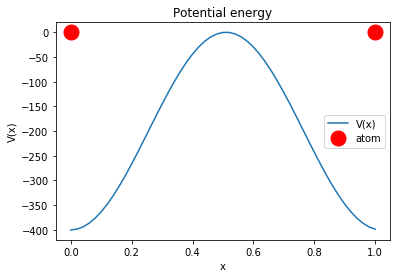

In [20]:
def vext_q(nG, V0):
    """
    Return only positive component
    """
    Vq = np.zeros(nG//2+1)
    Vq[0], Vq[1] = -V0/2, -V0/4
    return Vq

n = 1
V0 = 400
Vq_1D = vext_q(nG, V0)
Vext_x = np.fft.irfft(Vq_1D, nG)*nG
plt.plot(X, Vext_x, label='V(x)')
plt.xlabel('x')
plt.ylabel('V(x)')
atoms = plt.plot([0, 1], [0, 0], 'ro', label='atom')
plt.setp(atoms, markersize=15)
plt.title('Potential energy')
plt.legend()
plt.show()

Band gap between nearest energy band

      1. E1-E0=83.598

      2. E2-E1=77.830

      3. E3-E2=70.881

      ......
      


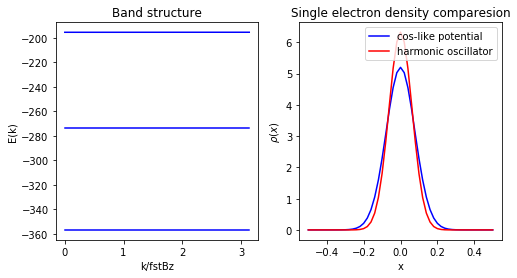

In [21]:
omega = 2*np.pi*np.sqrt(V0)
en_band_1D, uq = ed.solver1D(k_points, nG, Vq_1D)
mu = en_band_1D[0, 0] + 20
densG_1D = quantum_util.density1D(nk, nG, mu, en_band_1D, uq)

gap1 = en_band_1D[-1, 1] - en_band_1D[-1, 0]
gap2 = en_band_1D[-1, 2] - en_band_1D[-1, 1]
gap3 = en_band_1D[-1, 3] - en_band_1D[-1, 2]
print("""Band gap between nearest energy band\n
      1. E1-E0={:<.3f}\n
      2. E2-E1={:<.3f}\n
      3. E3-E2={:<.3f}\n
      ......
      """.format(gap1, gap2, gap3))

K = np.linspace(0, np.pi, nk)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(K, en_band_1D[:, 0], 'b')
ax1.plot(K, en_band_1D[:, 1], 'b')
ax1.plot(K, en_band_1D[:, 2], 'b')
ax1.set_xlabel('k/fstBz')
ax1.set_ylabel('E(k)')
ax1.set_title('Band structure')

densX_1D = np.fft.ifft(densG_1D)*nG
har_dens = lambda x: (np.sqrt(omega/np.pi))*np.exp(-omega*x**2)
X_ = np.linspace(-0.5, 0.5, nG)
har_densx = har_dens(X_)
densx_cell = np.fft.fftshift(densX_1D)
ax2.plot(X_, densx_cell, 'b', label='cos-like potential')
ax2.plot(X_, har_densx, 'r', label='harmonic oscillator')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel(r'$\rho(x)$')
ax2.set_title('Single electron density comparesion')
plt.show()